In [1]:
# Python Free Fermion Large Scale Simulation Platform (FermiNet) Tutorials
# Author: Bill Zhai pzhai@g.harvard.edu
# PI: Susanne F. Yelin
# Nov 30, 2022

In [2]:
# My PyFerm modules:
from Utils_torch_version import Network, get_nn_pairs, binary_basis, unpacknbits, initialize_sparse, \
    mnist_single_pdf, mix_rbf_kernel, kernel_expect

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy
import scipy.linalg
import time
import torch # PyTorch is required for this demo
import qiskit # Qiskit is required for this demo
import math
import seaborn as sns


# Example 4: Quantum Generative Model

The quantum circuit Born Machine (QCBM) is a quantum generative model. 

QCBM utilizes a multi-layer parametrized quantum circuit (MPQC) to evolve the initial/input quantum state $|\psi_0\rangle$ to some target state via unitary gates: $\left|\psi_{\theta}\right\rangle=U_{\theta}|\psi_0\rangle$, where $\theta$ are the parameters of the MPQ. One measures the outputs state in the computational basis to produce a classical sample (bit string) $x \sim p_{\boldsymbol{\theta}}(x)=\left|\left\langle x | \psi_{\theta}\right\rangle\right|^{2}$. Excitingly, the output probability densities of a general quantum circuit cannot be efficiently simulated by classical means, the QCBM is among the several proposals to show quantum supremacy. QCBM by minimizing the maximum mean discrepancy (MMD) loss using a Gaussian Kernel:

$\begin{equation}
    \begin{aligned}
\mathcal{L}&=\underset{x \sim p_{\theta}, y \sim p_{\theta}}{\mathbb{E}}[K(x, y)]-2 \underset{x \sim p_{\theta}, y \sim p^*}{\mathbb{E}}[K(x, y)]+\underset{x \sim p^*, y \sim p^*}{\mathbb{E}}[K(x, y)],
\end{aligned}
\end{equation}.$

In this tutorial, we use a simple multi-layer parametrized quantum circuit with related FreeFermiNet classes and functions.

We define one circuit gate Hamiltonian as $H_g$, and each gate corresponds to a continuous evolution $e^{-i\mathcal{H}_{g}t}$. A parametrized is a series of such evolutions:

$U_{total} = U_L U_{L-1}...U_{2} U_1, $

where $U_l$ is the $l$-th "layer" defined as:

$U_l = e^{-i\mathcal{H}_{l}t},$

where at each layer, $\mathcal{H}_{l}$ concerns interactionos of two Fermionic modes $i<j$, not necessarily nearest-neighbor. In this example, we use a simple construction (refer to Tutorial 1 for more details):

$\begin{equation}
    \begin{aligned}
        \mathcal{H}_{l} &=b_{i i} a_i^{\dagger} a_i+b_{j j} a_j^{\dagger} a_j+(c+di) a_i^{\dagger} a_j+(c-di) a_j^{\dagger} a_i \\ &= -\frac{1}{2} \left(b_{ii} Z_i + b_{jj} Z_j\right)+\frac{c}{2} \left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j + X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j \right)\\
        &+\frac{d}{2}\left(Y_i \left(\prod_{k=i+1}^{j-1} Z_k\right) X_j - X_i \left(\prod_{k=i+1}^{j-1} Z_k\right) Y_j \right),
    \end{aligned}
\end{equation}$

In [3]:
pdf_data_img,_ = mnist_single_pdf(0, 9, (5,5))

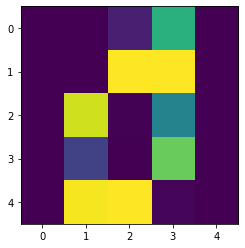

In [4]:
plt.imshow(pdf_data_img)

In [5]:
pdf_data = torch.zeros(2**5, dtype=torch.float)
pdf_data[:25] = torch.tensor(pdf_data_img.flatten(), dtype=torch.float)
print(pdf_data)

tensor([0.0000, 0.0000, 0.0123, 0.0900, 0.0000, 0.0000, 0.0000, 0.1415, 0.1415,
        0.0000, 0.0000, 0.1314, 0.0006, 0.0632, 0.0000, 0.0000, 0.0274, 0.0000,
        0.1085, 0.0000, 0.0000, 0.1398, 0.1415, 0.0022, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


/var/folders/66/87ywc69x2c5_cqkhm3p3f4l00000gn/T/ipykernel_59298/4032754336.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pdf_data[:25] = torch.tensor(pdf_data_img.flatten(), dtype=torch.float)


In [6]:
n_fermions = 5
factor = 10
N = factor * n_fermions
basis_m_n = binary_basis(geometry=(n_fermions,)) # The basis in the probability space

conn_list = [ [np.min(p), np.max(p)] for p in get_nn_pairs(geometry=(N,))]*2

print('conn_list', conn_list)
L = len(conn_list) # Number of layers

# 101010...10
x_input = torch.tensor([[1]*(N//factor)+[0]*(N-N//factor)]) if N%2==0 else torch.tensor([[1,0]*int(N/2)+[1]])

# Initialize the circuit
circuit = Network(conn_list, N)
print('circuit.parameters()', circuit.parameters())

# Initialize the circuit
circuit = Network(conn_list, N)

beta1 = 0.5
lr_G = 1e-1
optimizerG = torch.optim.Adam(circuit.parameters(), lr=lr_G, betas=(beta1, 0.999)) #The parameters are the th
def kl(p_data, probs_batch):
    return torch.sum(p_data * torch.log(p_data/(probs_batch+1e-12)))
def tv_sqr(p_data, probs_batch):
    return torch.sum(torch.square(probs_batch-p_data))


# MMD loss by tracking the full probability space [0.5, 0.1, 0.2, 0.25,4,10]
K = torch.tensor(mix_rbf_kernel(basis_m_n, basis_m_n, sigma_list=[0.002, 0.5, 0.1, 0.2, 0.25,4,10]), dtype=torch.float)
def exact_mmd(pdf_data, pdf_model): #input are tensors
    # print('debug pdf_data', pdf_data)
    # print('debug pdf_model', pdf_model)
    # parmas_L_by_4 = parmas_L_times_4.reshape((L, 4))
    # bij_vec = parmas_L_by_4[:,2]+parmas_L_by_4[:,3]*1j # the bij has a real part and a complex part
    # params_L_3 = np.concatenate((parmas_L_by_4[:,0:2], bij_vec[:,None]), axis=1)
    p_diff = pdf_data-pdf_model # Although this puts a constant term to the loss value, it is easier to code this way
    return kernel_expect(K, p_diff, p_diff)


conn_list [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [23, 24], [25, 26], [27, 28], [29, 30], [31, 32], [33, 34], [35, 36], [37, 38], [39, 40], [41, 42], [43, 44], [45, 46], [47, 48], [0, 49], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [23, 24], [25, 26], [27, 28], [29, 30], [31, 32], [33, 34], [35, 36], [37, 38], [39, 40], [41, 42], [43, 44], [45, 46], [47, 48], [0, 49]]
debug self.L 100
circuit.para

/Users/pengyuanzhai/Documents/Fermion_torch/Utils_torch_version.py:45: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646981653/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  return px@K@py.T


iter, obj (0, tensor(2.1788, grad_fn=<DotBackward0>))


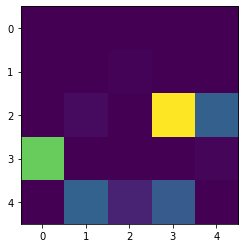

iter, obj (1, tensor(1.5114, grad_fn=<DotBackward0>))
iter, obj (2, tensor(1.0324, grad_fn=<DotBackward0>))
iter, obj (3, tensor(0.7970, grad_fn=<DotBackward0>))
iter, obj (4, tensor(0.6300, grad_fn=<DotBackward0>))
iter, obj (5, tensor(0.5482, grad_fn=<DotBackward0>))
iter, obj (6, tensor(0.5162, grad_fn=<DotBackward0>))
iter, obj (7, tensor(0.4827, grad_fn=<DotBackward0>))
iter, obj (8, tensor(0.4435, grad_fn=<DotBackward0>))
iter, obj (9, tensor(0.4162, grad_fn=<DotBackward0>))
iter, obj (10, tensor(0.3968, grad_fn=<DotBackward0>))
iter, obj (11, tensor(0.3809, grad_fn=<DotBackward0>))
iter, obj (12, tensor(0.3726, grad_fn=<DotBackward0>))
iter, obj (13, tensor(0.3687, grad_fn=<DotBackward0>))
iter, obj (14, tensor(0.3649, grad_fn=<DotBackward0>))
iter, obj (15, tensor(0.3611, grad_fn=<DotBackward0>))
iter, obj (16, tensor(0.3576, grad_fn=<DotBackward0>))
iter, obj (17, tensor(0.3545, grad_fn=<DotBackward0>))
iter, obj (18, tensor(0.3513, grad_fn=<DotBackward0>))
iter, obj (19, tens

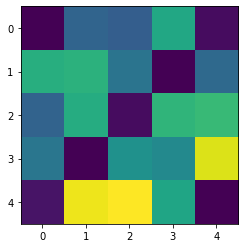

iter, obj (21, tensor(0.3404, grad_fn=<DotBackward0>))
iter, obj (22, tensor(0.3367, grad_fn=<DotBackward0>))
iter, obj (23, tensor(0.3334, grad_fn=<DotBackward0>))
iter, obj (24, tensor(0.3305, grad_fn=<DotBackward0>))
iter, obj (25, tensor(0.3281, grad_fn=<DotBackward0>))
iter, obj (26, tensor(0.3263, grad_fn=<DotBackward0>))
iter, obj (27, tensor(0.3250, grad_fn=<DotBackward0>))
iter, obj (28, tensor(0.3240, grad_fn=<DotBackward0>))
iter, obj (29, tensor(0.3233, grad_fn=<DotBackward0>))
iter, obj (30, tensor(0.3227, grad_fn=<DotBackward0>))
iter, obj (31, tensor(0.3224, grad_fn=<DotBackward0>))
iter, obj (32, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (33, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (34, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (35, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (36, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (37, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (38, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj 

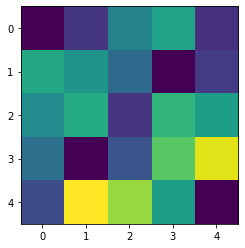

iter, obj (41, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (42, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (43, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (44, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (45, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (46, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (47, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (48, tensor(0.3228, grad_fn=<DotBackward0>))
iter, obj (49, tensor(0.3228, grad_fn=<DotBackward0>))
iter, obj (50, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (51, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (52, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (53, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (54, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (55, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (56, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (57, tensor(0.3207, grad_fn=<DotBackward0>))
iter, obj (58, tensor(0.3207, grad_fn=<DotBackward0>))
iter, obj 

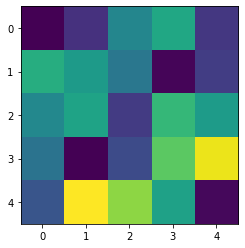

iter, obj (61, tensor(0.3206, grad_fn=<DotBackward0>))
iter, obj (62, tensor(0.3206, grad_fn=<DotBackward0>))
iter, obj (63, tensor(0.3206, grad_fn=<DotBackward0>))
iter, obj (64, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (65, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (66, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (67, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (68, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (69, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (70, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (71, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (72, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (73, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (74, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (75, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (76, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (77, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (78, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj 

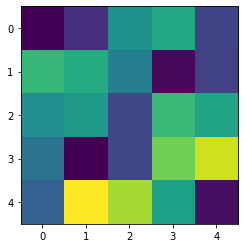

iter, obj (81, tensor(0.3230, grad_fn=<DotBackward0>))
iter, obj (82, tensor(0.3268, grad_fn=<DotBackward0>))
iter, obj (83, tensor(0.3314, grad_fn=<DotBackward0>))
iter, obj (84, tensor(0.3366, grad_fn=<DotBackward0>))
iter, obj (85, tensor(0.3305, grad_fn=<DotBackward0>))
iter, obj (86, tensor(0.3246, grad_fn=<DotBackward0>))
iter, obj (87, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (88, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (89, tensor(0.3207, grad_fn=<DotBackward0>))
iter, obj (90, tensor(0.3206, grad_fn=<DotBackward0>))
iter, obj (91, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (92, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (93, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (94, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (95, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (96, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (97, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (98, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj 

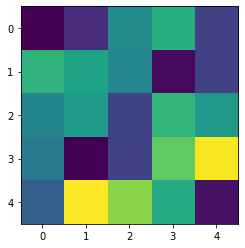

iter, obj (101, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (102, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (103, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (104, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (105, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (106, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (107, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (108, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (109, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (110, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (111, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (112, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (113, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (114, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (115, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (116, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (117, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (118, tensor(0.3202, grad_fn=<DotBackw

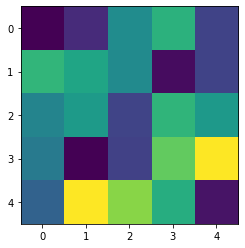

iter, obj (121, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (122, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (123, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (124, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (125, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (126, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (127, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (128, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (129, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (130, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (131, tensor(0.3207, grad_fn=<DotBackward0>))
iter, obj (132, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (133, tensor(0.3226, grad_fn=<DotBackward0>))
iter, obj (134, tensor(0.3242, grad_fn=<DotBackward0>))
iter, obj (135, tensor(0.3256, grad_fn=<DotBackward0>))
iter, obj (136, tensor(0.3258, grad_fn=<DotBackward0>))
iter, obj (137, tensor(0.3281, grad_fn=<DotBackward0>))
iter, obj (138, tensor(0.3313, grad_fn=<DotBackw

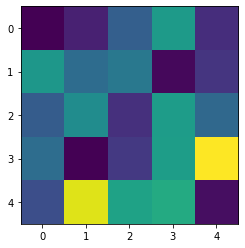

iter, obj (141, tensor(0.3288, grad_fn=<DotBackward0>))
iter, obj (142, tensor(0.3235, grad_fn=<DotBackward0>))
iter, obj (143, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (144, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (145, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (146, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (147, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (148, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (149, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (150, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (151, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (152, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (153, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (154, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (155, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (156, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (157, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (158, tensor(0.3201, grad_fn=<DotBackw

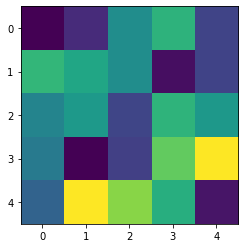

iter, obj (161, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (162, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (163, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (164, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (165, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (166, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (167, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (168, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (169, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (170, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (171, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (172, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (173, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (174, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (175, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (176, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (177, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (178, tensor(0.3201, grad_fn=<DotBackw

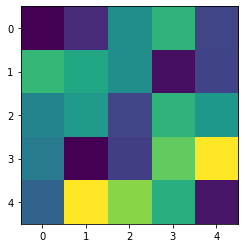

iter, obj (181, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (182, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (183, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (184, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (185, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (186, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (187, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (188, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (189, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (190, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (191, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (192, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (193, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (194, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (195, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (196, tensor(0.3257, grad_fn=<DotBackward0>))
iter, obj (197, tensor(0.3310, grad_fn=<DotBackward0>))
iter, obj (198, tensor(0.3353, grad_fn=<DotBackw

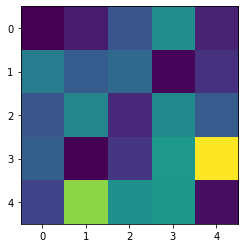

iter, obj (201, tensor(0.3423, grad_fn=<DotBackward0>))
iter, obj (202, tensor(0.3328, grad_fn=<DotBackward0>))
iter, obj (203, tensor(0.3250, grad_fn=<DotBackward0>))
iter, obj (204, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (205, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (206, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (207, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (208, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (209, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (210, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (211, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (212, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (213, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (214, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (215, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (216, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (217, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (218, tensor(0.3201, grad_fn=<DotBackw

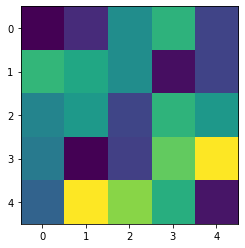

iter, obj (221, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (222, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (223, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (224, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (225, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (226, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (227, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (228, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (229, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (230, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (231, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (232, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (233, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (234, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (235, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (236, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (237, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (238, tensor(0.3201, grad_fn=<DotBackw

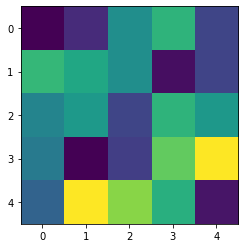

iter, obj (241, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (242, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (243, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (244, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (245, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (246, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (247, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (248, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (249, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (250, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (251, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (252, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (253, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (254, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (255, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (256, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (257, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (258, tensor(0.3201, grad_fn=<DotBackw

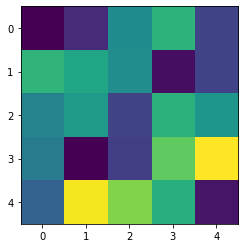

iter, obj (261, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (262, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (263, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (264, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (265, tensor(0.3206, grad_fn=<DotBackward0>))
iter, obj (266, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (267, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (268, tensor(0.3228, grad_fn=<DotBackward0>))
iter, obj (269, tensor(0.3253, grad_fn=<DotBackward0>))
iter, obj (270, tensor(0.3283, grad_fn=<DotBackward0>))
iter, obj (271, tensor(0.3348, grad_fn=<DotBackward0>))
iter, obj (272, tensor(0.3380, grad_fn=<DotBackward0>))
iter, obj (273, tensor(0.3477, grad_fn=<DotBackward0>))
iter, obj (274, tensor(0.3468, grad_fn=<DotBackward0>))
iter, obj (275, tensor(0.3453, grad_fn=<DotBackward0>))
iter, obj (276, tensor(0.3349, grad_fn=<DotBackward0>))
iter, obj (277, tensor(0.3264, grad_fn=<DotBackward0>))
iter, obj (278, tensor(0.3210, grad_fn=<DotBackw

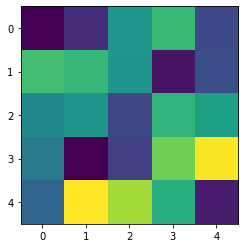

iter, obj (281, tensor(0.3207, grad_fn=<DotBackward0>))
iter, obj (282, tensor(0.3206, grad_fn=<DotBackward0>))
iter, obj (283, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (284, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (285, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (286, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (287, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (288, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (289, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (290, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (291, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (292, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (293, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (294, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (295, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (296, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (297, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (298, tensor(0.3201, grad_fn=<DotBackw

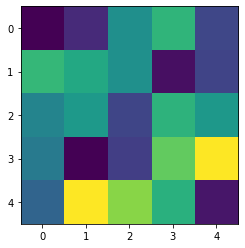

iter, obj (301, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (302, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (303, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (304, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (305, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (306, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (307, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (308, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (309, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (310, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (311, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (312, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (313, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (314, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (315, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (316, tensor(0.3201, grad_fn=<DotBackward0>))
iter, obj (317, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (318, tensor(0.3202, grad_fn=<DotBackw

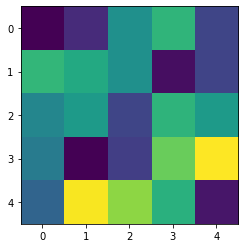

iter, obj (321, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (322, tensor(0.3202, grad_fn=<DotBackward0>))
iter, obj (323, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (324, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (325, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (326, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (327, tensor(0.3207, grad_fn=<DotBackward0>))
iter, obj (328, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (329, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (330, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (331, tensor(0.3225, grad_fn=<DotBackward0>))
iter, obj (332, tensor(0.3236, grad_fn=<DotBackward0>))
iter, obj (333, tensor(0.3244, grad_fn=<DotBackward0>))
iter, obj (334, tensor(0.3256, grad_fn=<DotBackward0>))
iter, obj (335, tensor(0.3263, grad_fn=<DotBackward0>))
iter, obj (336, tensor(0.3269, grad_fn=<DotBackward0>))
iter, obj (337, tensor(0.3274, grad_fn=<DotBackward0>))
iter, obj (338, tensor(0.3277, grad_fn=<DotBackw

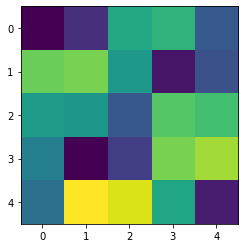

iter, obj (341, tensor(0.3281, grad_fn=<DotBackward0>))
iter, obj (342, tensor(0.3291, grad_fn=<DotBackward0>))
iter, obj (343, tensor(0.3280, grad_fn=<DotBackward0>))
iter, obj (344, tensor(0.3285, grad_fn=<DotBackward0>))
iter, obj (345, tensor(0.3260, grad_fn=<DotBackward0>))
iter, obj (346, tensor(0.3248, grad_fn=<DotBackward0>))
iter, obj (347, tensor(0.3227, grad_fn=<DotBackward0>))
iter, obj (348, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (349, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (350, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (351, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (352, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (353, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (354, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (355, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (356, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (357, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (358, tensor(0.3218, grad_fn=<DotBackw

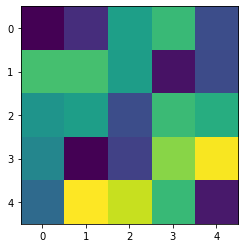

iter, obj (361, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (362, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (363, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (364, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (365, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (366, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (367, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (368, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (369, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (370, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (371, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (372, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (373, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (374, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (375, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (376, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (377, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (378, tensor(0.3212, grad_fn=<DotBackw

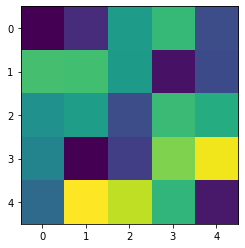

iter, obj (381, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (382, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (383, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (384, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (385, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (386, tensor(0.3224, grad_fn=<DotBackward0>))
iter, obj (387, tensor(0.3226, grad_fn=<DotBackward0>))
iter, obj (388, tensor(0.3227, grad_fn=<DotBackward0>))
iter, obj (389, tensor(0.3229, grad_fn=<DotBackward0>))
iter, obj (390, tensor(0.3231, grad_fn=<DotBackward0>))
iter, obj (391, tensor(0.3231, grad_fn=<DotBackward0>))
iter, obj (392, tensor(0.3233, grad_fn=<DotBackward0>))
iter, obj (393, tensor(0.3233, grad_fn=<DotBackward0>))
iter, obj (394, tensor(0.3234, grad_fn=<DotBackward0>))
iter, obj (395, tensor(0.3233, grad_fn=<DotBackward0>))
iter, obj (396, tensor(0.3235, grad_fn=<DotBackward0>))
iter, obj (397, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (398, tensor(0.3234, grad_fn=<DotBackw

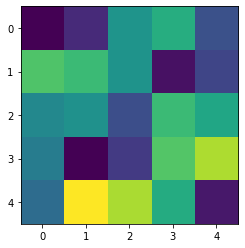

iter, obj (401, tensor(0.3226, grad_fn=<DotBackward0>))
iter, obj (402, tensor(0.3226, grad_fn=<DotBackward0>))
iter, obj (403, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (404, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (405, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (406, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (407, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (408, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (409, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (410, tensor(0.3226, grad_fn=<DotBackward0>))
iter, obj (411, tensor(0.3228, grad_fn=<DotBackward0>))
iter, obj (412, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (413, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (414, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (415, tensor(0.3229, grad_fn=<DotBackward0>))
iter, obj (416, tensor(0.3227, grad_fn=<DotBackward0>))
iter, obj (417, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (418, tensor(0.3220, grad_fn=<DotBackw

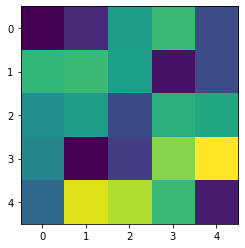

iter, obj (421, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (422, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (423, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (424, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (425, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (426, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (427, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (428, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (429, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (430, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (431, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (432, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (433, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (434, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (435, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (436, tensor(0.3230, grad_fn=<DotBackward0>))
iter, obj (437, tensor(0.3236, grad_fn=<DotBackward0>))
iter, obj (438, tensor(0.3247, grad_fn=<DotBackw

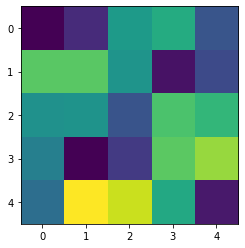

iter, obj (441, tensor(0.3267, grad_fn=<DotBackward0>))
iter, obj (442, tensor(0.3275, grad_fn=<DotBackward0>))
iter, obj (443, tensor(0.3268, grad_fn=<DotBackward0>))
iter, obj (444, tensor(0.3267, grad_fn=<DotBackward0>))
iter, obj (445, tensor(0.3255, grad_fn=<DotBackward0>))
iter, obj (446, tensor(0.3246, grad_fn=<DotBackward0>))
iter, obj (447, tensor(0.3235, grad_fn=<DotBackward0>))
iter, obj (448, tensor(0.3226, grad_fn=<DotBackward0>))
iter, obj (449, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (450, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (451, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (452, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (453, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (454, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (455, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (456, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (457, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (458, tensor(0.3217, grad_fn=<DotBackw

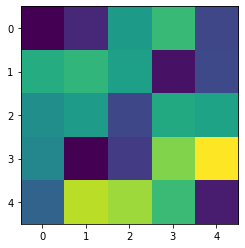

iter, obj (461, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (462, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (463, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (464, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (465, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (466, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (467, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (468, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (469, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (470, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (471, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (472, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (473, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (474, tensor(0.3225, grad_fn=<DotBackward0>))
iter, obj (475, tensor(0.3229, grad_fn=<DotBackward0>))
iter, obj (476, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (477, tensor(0.3235, grad_fn=<DotBackward0>))
iter, obj (478, tensor(0.3239, grad_fn=<DotBackw

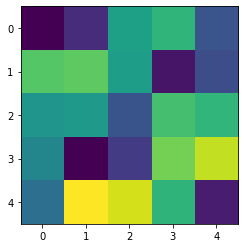

iter, obj (481, tensor(0.3242, grad_fn=<DotBackward0>))
iter, obj (482, tensor(0.3242, grad_fn=<DotBackward0>))
iter, obj (483, tensor(0.3239, grad_fn=<DotBackward0>))
iter, obj (484, tensor(0.3237, grad_fn=<DotBackward0>))
iter, obj (485, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (486, tensor(0.3229, grad_fn=<DotBackward0>))
iter, obj (487, tensor(0.3224, grad_fn=<DotBackward0>))
iter, obj (488, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (489, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (490, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (491, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (492, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (493, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (494, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (495, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (496, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (497, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (498, tensor(0.3212, grad_fn=<DotBackw

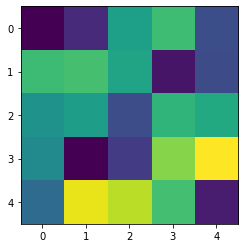

iter, obj (501, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (502, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (503, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (504, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (505, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (506, tensor(0.3225, grad_fn=<DotBackward0>))
iter, obj (507, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (508, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (509, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (510, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (511, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (512, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (513, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (514, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (515, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (516, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (517, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (518, tensor(0.3219, grad_fn=<DotBackw

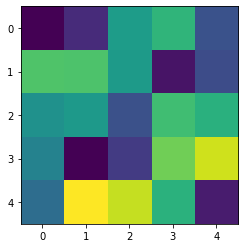

iter, obj (521, tensor(0.3236, grad_fn=<DotBackward0>))
iter, obj (522, tensor(0.3246, grad_fn=<DotBackward0>))
iter, obj (523, tensor(0.3253, grad_fn=<DotBackward0>))
iter, obj (524, tensor(0.3266, grad_fn=<DotBackward0>))
iter, obj (525, tensor(0.3268, grad_fn=<DotBackward0>))
iter, obj (526, tensor(0.3275, grad_fn=<DotBackward0>))
iter, obj (527, tensor(0.3268, grad_fn=<DotBackward0>))
iter, obj (528, tensor(0.3264, grad_fn=<DotBackward0>))
iter, obj (529, tensor(0.3252, grad_fn=<DotBackward0>))
iter, obj (530, tensor(0.3242, grad_fn=<DotBackward0>))
iter, obj (531, tensor(0.3230, grad_fn=<DotBackward0>))
iter, obj (532, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (533, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (534, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (535, tensor(0.3209, grad_fn=<DotBackward0>))
iter, obj (536, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (537, tensor(0.3208, grad_fn=<DotBackward0>))
iter, obj (538, tensor(0.3208, grad_fn=<DotBackw

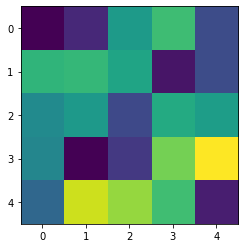

iter, obj (541, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (542, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (543, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (544, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (545, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (546, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (547, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (548, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (549, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (550, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (551, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (552, tensor(0.3215, grad_fn=<DotBackward0>))
iter, obj (553, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (554, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (555, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (556, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (557, tensor(0.3224, grad_fn=<DotBackward0>))
iter, obj (558, tensor(0.3226, grad_fn=<DotBackw

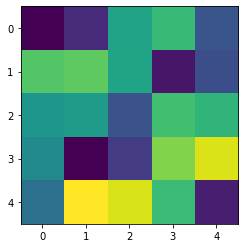

iter, obj (561, tensor(0.3234, grad_fn=<DotBackward0>))
iter, obj (562, tensor(0.3236, grad_fn=<DotBackward0>))
iter, obj (563, tensor(0.3237, grad_fn=<DotBackward0>))
iter, obj (564, tensor(0.3238, grad_fn=<DotBackward0>))
iter, obj (565, tensor(0.3237, grad_fn=<DotBackward0>))
iter, obj (566, tensor(0.3237, grad_fn=<DotBackward0>))
iter, obj (567, tensor(0.3234, grad_fn=<DotBackward0>))
iter, obj (568, tensor(0.3232, grad_fn=<DotBackward0>))
iter, obj (569, tensor(0.3228, grad_fn=<DotBackward0>))
iter, obj (570, tensor(0.3225, grad_fn=<DotBackward0>))
iter, obj (571, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (572, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (573, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (574, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (575, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (576, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (577, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (578, tensor(0.3210, grad_fn=<DotBackw

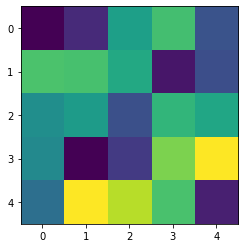

iter, obj (581, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (582, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (583, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (584, tensor(0.3213, grad_fn=<DotBackward0>))
iter, obj (585, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (586, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (587, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (588, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (589, tensor(0.3221, grad_fn=<DotBackward0>))
iter, obj (590, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (591, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (592, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (593, tensor(0.3220, grad_fn=<DotBackward0>))
iter, obj (594, tensor(0.3219, grad_fn=<DotBackward0>))
iter, obj (595, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (596, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (597, tensor(0.3214, grad_fn=<DotBackward0>))
iter, obj (598, tensor(0.3214, grad_fn=<DotBackw

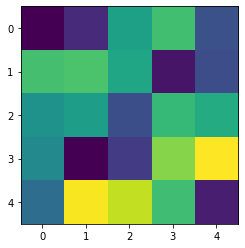

iter, obj (601, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (602, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (603, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (604, tensor(0.3228, grad_fn=<DotBackward0>))
iter, obj (605, tensor(0.3236, grad_fn=<DotBackward0>))
iter, obj (606, tensor(0.3246, grad_fn=<DotBackward0>))
iter, obj (607, tensor(0.3256, grad_fn=<DotBackward0>))
iter, obj (608, tensor(0.3269, grad_fn=<DotBackward0>))
iter, obj (609, tensor(0.3274, grad_fn=<DotBackward0>))
iter, obj (610, tensor(0.3282, grad_fn=<DotBackward0>))
iter, obj (611, tensor(0.3275, grad_fn=<DotBackward0>))
iter, obj (612, tensor(0.3269, grad_fn=<DotBackward0>))
iter, obj (613, tensor(0.3254, grad_fn=<DotBackward0>))
iter, obj (614, tensor(0.3240, grad_fn=<DotBackward0>))
iter, obj (615, tensor(0.3227, grad_fn=<DotBackward0>))
iter, obj (616, tensor(0.3217, grad_fn=<DotBackward0>))
iter, obj (617, tensor(0.3211, grad_fn=<DotBackward0>))
iter, obj (618, tensor(0.3207, grad_fn=<DotBackw

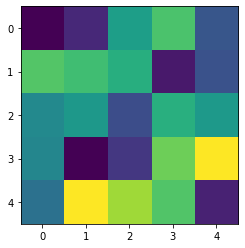

iter, obj (621, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (622, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (623, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (624, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (625, tensor(0.3203, grad_fn=<DotBackward0>))
iter, obj (626, tensor(0.3204, grad_fn=<DotBackward0>))
iter, obj (627, tensor(0.3205, grad_fn=<DotBackward0>))
iter, obj (628, tensor(0.3206, grad_fn=<DotBackward0>))
iter, obj (629, tensor(0.3207, grad_fn=<DotBackward0>))
iter, obj (630, tensor(0.3210, grad_fn=<DotBackward0>))
iter, obj (631, tensor(0.3212, grad_fn=<DotBackward0>))
iter, obj (632, tensor(0.3216, grad_fn=<DotBackward0>))
iter, obj (633, tensor(0.3218, grad_fn=<DotBackward0>))
iter, obj (634, tensor(0.3223, grad_fn=<DotBackward0>))
iter, obj (635, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (636, tensor(0.3225, grad_fn=<DotBackward0>))
iter, obj (637, tensor(0.3222, grad_fn=<DotBackward0>))
iter, obj (638, tensor(0.3222, grad_fn=<DotBackw

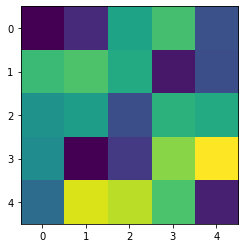

KeyboardInterrupt: 

In [7]:
n_space = basis_m_n.shape[0] # The number of total probability patterns
batchsize = 1024
num_batches = n_space//batchsize if n_space%batchsize==0 else n_space//batchsize+1

for itr in range(10000): # At each iteration, measure the kl divergence and update
    #probs_theta_valid_samples = torch.zeros(bas_samples.shape[0]) # to collect the model probabilities at valid patterns
    pdf_model = torch.zeros(basis_m_n.shape[0]) # To keep full pdf for exact calculation of the MMD loss


    circuit.zero_grad() # clear the parameter gradients
    obj = torch.tensor(0.0)
    # Loop through all possible patterns in the total probability space
    for i in range(num_batches):
        y_batch = basis_m_n[i*batchsize:(i+1)*batchsize]
        x_batch = x_input.repeat_interleave(y_batch.shape[0], axis=0)
        sub_mask_batch = (torch.tensor([ [1]*(N//factor)+[0]*(N-N//factor) ])).repeat(y_batch.shape[0], 1) # Measure the first half of the qubits

        probs_batch = circuit.forward_partial_observation(y_batch, x_batch, sub_mask_batch)
        # probs_batch = torch.conj(amps_batch)*amps_batch # this is still torch.cfloat
        # Only keep the real part, as all information goes to the real part
        probs_batch = probs_batch.real
        #print('probs_batch', probs_batch)
        pdf_model[i*batchsize:(i+1)*batchsize] = probs_batch # Keep track of the gradient, as this directly goes into the loss calculation

    # in the case of calculating the exact MMD loss, which cannot be written as a sum
    obj = exact_mmd(pdf_data, pdf_model)

    obj.backward()
    optimizerG.step()
    print('iter, obj', (itr, obj))

    if itr % 20 == 0:
        #print('predicted', probs_theta_valid_samples)
        plt.plot(pdf_data.detach().numpy(), '^-')
        plt.plot(pdf_model.detach().numpy(), 'x-')
        plt.savefig('kl_training_figs/iter_'+str(itr)+'.png')
        plt.close()

        # plot the gradients
        grads_l_list = []
        for l in range(L):
            # each layer has four parameters
            grads_l = np.array([[circuit.V_l_module_list[l].bii.grad.detach().numpy()[0], circuit.V_l_module_list[l].bjj.grad.detach().numpy()[0],\
             circuit.V_l_module_list[l].bij_real.grad.detach().numpy()[0], \
            circuit.V_l_module_list[l].bij_img.grad.detach().numpy()[0]]])

            grads_l_list.append(grads_l)

        grads_4_by_l = np.concatenate(grads_l_list, axis=0).T

        ax = sns.heatmap( grads_4_by_l , linewidth = 0.5 , cmap = 'coolwarm' )
        plt.xlabel('layer No.')
        plt.ylabel('thetas 0, 1, 2, 3')
        plt.savefig('kl_training_gradients/iter_'+str(itr)+'.png')
        plt.close()

        plt.figure()
        plt.imshow(pdf_model[:25].detach().numpy().reshape(5,5))
        plt.savefig('kl_training_gradients/img_iter_'+str(itr)+'.png')
        plt.imsave('kl_training_gradients/img_iter_'+str(itr)+'.png',pdf_model[:25].detach().numpy().reshape(5,5))
        plt.show()

In [ ]:
pdf_model = torch.zeros(basis_m_n.shape[0])

In [ ]:
pdf_model.reshape(8,8)

In [ ]:
pdf_model

In [ ]:
K

In [ ]:
K

In [ ]:
P_diff